In [133]:
%pip install tensorflow librosa matplotlib

Note: you may need to restart the kernel to use updated packages.


In [134]:
import tensorflow as tf
import librosa 
import numpy as np
import matplotlib.pyplot as plt

In [189]:
file_path = 'recordings/ugasi/ugasi.wav' 
signal, sample_rate = librosa.load(file_path, sr=None)  # sr=None keeps the original sample rate
print("Sample Rate:", sample_rate)
print("Signal Shape:", signal.shape)

print(signal)


Sample Rate: 44100
Signal Shape: (44032,)
[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ...  7.3242188e-04
  8.2397461e-04  5.4931641e-04]


In [190]:
signal_tensor = tf.convert_to_tensor(signal, dtype=tf.float32)
signal_tensor = tf.expand_dims(signal_tensor, 0)  # Add batch dimension

print(signal_tensor.shape)

(1, 44032)


In [211]:
# Parameters for STFT and MFCCs
frame_length = 128
frame_step = 32 
fft_length = frame_length
num_mel_bins = 80
lower_edge_hertz = 80.0
upper_edge_hertz = 7600.0

# Compute STFT (Short-Time Fourier Transform)
stfts = tf.signal.stft(
    signal_tensor,  # Use the first (and only) element of the batch
    frame_length=frame_length,
    frame_step=frame_step,
    fft_length=fft_length,
    window_fn=tf.signal.hamming_window
)

spectrograms = tf.abs(stfts)
np.savetxt("spectro_python.txt", spectrograms[0], fmt='%.6f') 
print(spectrograms.shape)

# Mel filterbank
num_spectrogram_bins = stfts.shape[-1]
print("Number of spectogram (frequency) bins:", num_spectrogram_bins)

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=num_mel_bins,
    num_spectrogram_bins=num_spectrogram_bins,
    sample_rate=sample_rate,
    lower_edge_hertz=lower_edge_hertz,
    upper_edge_hertz=upper_edge_hertz
)

print(linear_to_mel_weight_matrix.shape)

(1, 1373, 65)
Number of spectogram (frequency) bins: 65
(65, 80)


In [212]:
# Apply the mel filterbank
mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, axes=1)
print(mel_spectrograms.shape)
mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate([num_mel_bins]))
print(mel_spectrograms.shape)
np.savetxt("mel_spectro_python.txt", mel_spectrograms[0], fmt='%.6f') 



(1, 1373, 80)
(1, 1373, 80)


In [213]:


# Compute log-magnitude mel-spectrograms
log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
np.savetxt("log_mel_spectro_python.txt", log_mel_spectrograms[0], fmt='%.6f') 
print(log_mel_spectrograms.shape)

# Compute MFCCs from log_mel_spectrograms and take the first 13 coefficients
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :13]
np.savetxt("mfccs_python.txt", mfccs[0], fmt='%.6f') 
print("MFCCs shape:", mfccs.shape)

# Remove batch dimension and convert to NumPy for further processing or visualization
mfccs = mfccs.numpy()

print("MFCCs shape:", mfccs.shape)

(1, 1373, 80)
MFCCs shape: (1, 1373, 13)
MFCCs shape: (1, 1373, 13)


In [214]:
# Remove the batch dimension for visualization
mfccs_reshaped = mfccs[0]  # Shape: (857, 13)
print(mfccs_reshaped.shape)

(1373, 13)


In [215]:
mfccs_file_path = "mfccs_c.txt"  # Change this to your MFCC file path
mfccs_c = np.loadtxt(mfccs_file_path)
print(mfccs_c.shape)

(1373, 13)


Shapes are the same.


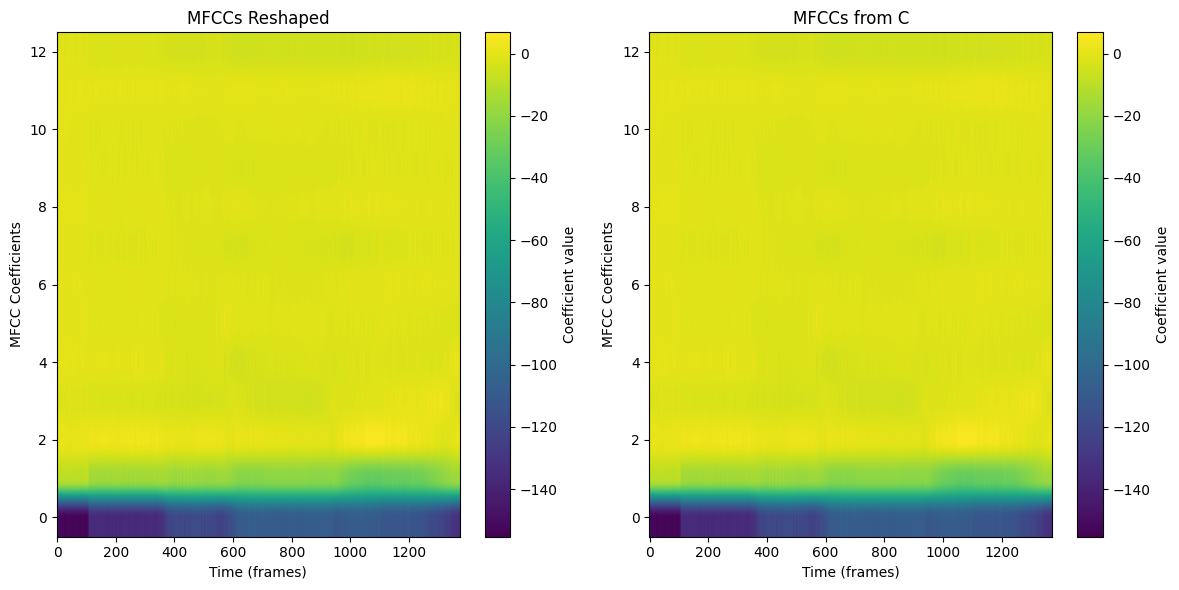

The MFCCs are different.
Mean Squared Error between the two MFCC sets: 0.000017
Mean MFCCs from Reshaped: [-120.91482     -20.623049      1.9333396    -2.1770785    -1.6143348
   -1.2597352    -0.7913324    -2.131581     -0.6311526    -1.7116861
   -1.2278535     0.40479755   -3.6659946 ]
Mean MFCCs from C: [-120.91526814  -20.62314722    1.92934673   -2.17705121   -1.61425435
   -1.26067718   -0.78905196   -2.13322786   -0.62424956   -1.70981356
   -1.22330535    0.40331044   -3.67285112]
Variance MFCCs from Reshaped: [191.14615     36.627026     3.27699      3.9815235    2.1119518
   0.77498335   0.6664491    1.0799779    0.6482286    0.7635389
   0.43446875   0.49453154   1.6237882 ]
Variance MFCCs from C: [191.14524027  36.6304727    3.27702221   3.98123236   2.11218934
   0.77503373   0.666291     1.07921273   0.64779897   0.76329959
   0.43428295   0.49484347   1.62427173]
Mean difference: [4.50327596e-04 9.84332377e-05 3.99287038e-03 2.72757292e-05
 8.04750150e-05 9.41956909e-04

In [216]:
# Step 1: Check shapes
if mfccs_reshaped.shape != mfccs_c.shape:
    print("Shapes are different!")
    print("Shape of MFCCs Reshaped:", mfccs_reshaped.shape)
    print("Shape of MFCCs C:", mfccs_c.shape)
else:
    print("Shapes are the same.")

# Step 2: Visualize the MFCCs side by side
plt.figure(figsize=(12, 6))

# Plot MFCCs from reshaped data
plt.subplot(1, 2, 1)
plt.imshow(mfccs_reshaped.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('MFCCs Reshaped')
plt.xlabel('Time (frames)')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='Coefficient value')

# Plot MFCCs from C data
plt.subplot(1, 2, 2)
plt.imshow(mfccs_c.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('MFCCs from C')
plt.xlabel('Time (frames)')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='Coefficient value')

plt.tight_layout()
plt.show()

# Step 3: Quantitative comparison
# Calculate absolute difference
difference = np.abs(mfccs_reshaped - mfccs_c)

# Step 4: Check if they are equal within a small tolerance
tolerance = 1e-6  # Define a small tolerance
if np.all(difference < tolerance):
    print("The MFCCs are identical within the tolerance.")
else:
    print("The MFCCs are different.")
    # Mean Squared Error
    mse = np.mean(difference**2)
    print(f"Mean Squared Error between the two MFCC sets: {mse:.6f}")

# Step 5: Mean and Variance Comparison
mean_mfcc_reshaped = np.mean(mfccs_reshaped, axis=0)
mean_mfcc_c = np.mean(mfccs_c, axis=0)

print("Mean MFCCs from Reshaped:", mean_mfcc_reshaped)
print("Mean MFCCs from C:", mean_mfcc_c)

# Variance
var_mfcc_reshaped = np.var(mfccs_reshaped, axis=0)
var_mfcc_c = np.var(mfccs_c, axis=0)

print("Variance MFCCs from Reshaped:", var_mfcc_reshaped)
print("Variance MFCCs from C:", var_mfcc_c)

# Final comparison of means and variances
mean_difference = np.abs(mean_mfcc_reshaped - mean_mfcc_c)
var_difference = np.abs(var_mfcc_reshaped - var_mfcc_c)

print("Mean difference:", mean_difference)
print("Variance difference:", var_difference)

[[0.00251783 0.00295687 0.0056331  ... 0.00261754 0.00966109 0.00792776]
 [0.01016187 0.00506588 0.00321488 ... 0.00079562 0.00247399 0.00835897]
 [0.0072789  0.00282537 0.00498254 ... 0.00091504 0.00032798 0.00628864]
 ...
 [0.00263944 0.00337165 0.00111043 ... 0.00710942 0.00414468 0.00383951]
 [0.00065601 0.00086192 0.0035221  ... 0.0040353  0.00105089 0.00694783]
 [0.00146454 0.00047136 0.00441312 ... 0.0035913  0.00078064 0.00648689]]


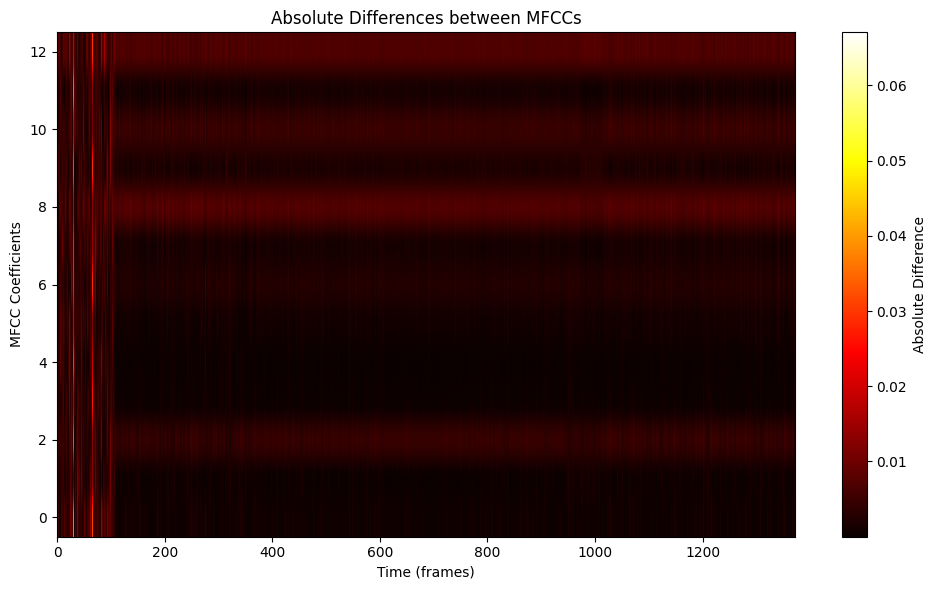

In [217]:
# Plot absolute differences
difference_abs = np.abs(mfccs_reshaped - mfccs_c)
print(difference_abs)

plt.figure(figsize=(10, 6))
plt.imshow(difference_abs.T, aspect='auto', origin='lower', cmap='hot')
plt.title('Absolute Differences between MFCCs')
plt.xlabel('Time (frames)')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='Absolute Difference')
plt.tight_layout()
plt.show()